# Google Docs Model Checkpoint

In [1]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials

from datetime import datetime as dt

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout, MaxPooling1D, Conv2D, Conv1D, InputLayer, Dropout, MaxPooling2D, BatchNormalization
from keras.losses import MSE
from keras.optimizers import SGD, Adam
from keras.callbacks import Callback, ModelCheckpoint
import keras.backend as K
from keras.models import load_model

import numpy as np
import torch
import matplotlib.pyplot as plt
import datetime
import tensorflow as tf
import os

from sklearn.metrics import r2_score
from synthetic_torch_helpers import SynH5Dataset
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


***

# Simple google sheets manipulation

In [2]:
# use creds to create a client to interact with the Google Drive API
scope = ['https://spreadsheets.google.com/feeds','https://www.googleapis.com/auth/drive']
creds = ServiceAccountCredentials.from_json_keyfile_name('./ModelTracker-004be3368142.json', scope)
# gc = gspread.authorize(creds)

In [4]:
sheet = gc.open("Model Tracking").sheet1

In [14]:
sheet.append_row([1, 2, 3, 'WOW'])

{'spreadsheetId': '1pP_mPockicOJURjygCs8XPF2IpZod-h1RXNd0HkpOPE',
 'tableRange': 'Sheet1!A1:D11',
 'updates': {'spreadsheetId': '1pP_mPockicOJURjygCs8XPF2IpZod-h1RXNd0HkpOPE',
  'updatedRange': 'Sheet1!A12:D12',
  'updatedRows': 1,
  'updatedColumns': 4,
  'updatedCells': 4}}

***

# Making the callback

In [42]:
class GoogleSheetsWriter(Callback):
    """
    """
    
    def __init__(self, json_keyfile, training_spreadsheet, model_info, exp_info, *args, **kwargs):
        super(GoogleSheetsWriter, self).__init__(*args, **kwargs)  
        
        # use creds to create a client to interact with the Google Drive API
        scope = ['https://spreadsheets.google.com/feeds','https://www.googleapis.com/auth/drive']
        creds = ServiceAccountCredentials.from_json_keyfile_name(json_keyfile, scope)
        self.gc = gspread.authorize(creds)
        
        # open the training sheet and make a new worksheet.
        self.spreadsheet = self.gc.open(training_spreadsheet)
        self.ws = self.spreadsheet.add_worksheet('TrainingData_{}'.format(dt.now().strftime("%Y-%m-%d-%H_%M_%S")), 10, 10)

        # writing model info
        self.ws.append_row(list(model_info.keys()))
        self.ws.append_row(list(model_info.values()))
        
        # writing experiment info
        self.ws.append_row(list(exp_info.keys()))
        self.ws.append_row(list(exp_info.values()))
                 
    def on_epoch_end(self, epoch, logs={}):
        # writing evaluation metrics.
        if len(self.ws.get_all_values()) <= 5:
            self.ws.append_row(['epoch'] + list(logs.keys()))
        self.ws.append_row([epoch] + list(logs.values()))

***

# Setting up Data

### Loading Datasets

In [2]:
train_dataset = SynH5Dataset(filename="generated_sets/syn_flux_dataset_ez1.h5", load_to_memory=True)
val_dataset = SynH5Dataset(filename="generated_sets/syn_flux_dataset_ez1.h5", load_to_memory=True)

train_dataset.flux = train_dataset.flux.swapaxes(1, 2)
val_dataset.flux = val_dataset.flux.swapaxes(1, 2)

list(map(lambda x: x.shape, [train_dataset.flux, train_dataset.zs, val_dataset.flux, val_dataset.zs]))

***

### Custom Metrics

In [44]:
kms = 300
c = 299792.458 #Speed of Light in kms
z_tol = np.sqrt((1+kms/c)/(1-kms/c))-1 

(array([1289.,  668., 1392.,  663.,  621., 1390.,  600., 1379.,  679.,
        1319.]),
 array([0.   , 0.014, 0.028, 0.042, 0.056, 0.07 , 0.084, 0.098, 0.112,
        0.126, 0.14 ], dtype=float32),
 <a list of 10 Patch objects>)

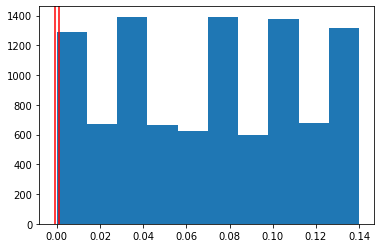

In [45]:
plt.axvline(z_tol,c='red')
plt.axvline(-z_tol,c='red')
plt.hist(val_dataset.zs)

In [46]:
def sci_standard(y_t, y_p):
    return K.mean(K.less_equal(np.abs(y_t - y_p), z_tol))

In [47]:
class EndEpochMetric(Callback):
    """
    This callback will evaluate 
    """
    
    def __init__(self, metrics, datasets, *args, **kwargs):
        super(EndEpochMetric, self).__init__(*args, **kwargs)
        self.metrics = metrics
        self.datasets = datasets
    
    def on_epoch_end(self, epoch, logs={}):
        for ix, (dataset_name, x, y) in enumerate(self.datasets):
            for cur_metric in self.metrics:
                v = cur_metric(self.model.predict(x), y)
                if isinstance(v, tf.Tensor):
                    v = K.eval(v)
                logs[dataset_name + '_custom_' + cur_metric.__name__] = float(v)

***

# Model Architecture

In [48]:
def create_complex():
    model = Sequential()
#     model.add(InputLayer(input_shape=(1, 4563)))
    
    model.add(Conv1D(filters=2, kernel_size=10, input_shape=(4563,1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Flatten())
    
    model.add(Dense(1024))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(.50))     
    
    
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(.50))
    
    model.add(Dense(1))
    model.compile(loss=MSE, optimizer=Adam(lr=0.001), metrics=['mae', 'mape', 'cosine'])
    return model

In [49]:
mod = create_complex()
mod

In [50]:
epm = EndEpochMetric([sci_standard, r2_score], datasets=[('train', train_dataset.flux, train_dataset.zs), ('val', val_dataset.flux, val_dataset.zs)])

In [51]:
gsw_clb = GoogleSheetsWriter(json_keyfile='./ModelTracker-004be3368142.json', training_spreadsheet='Model Tracking', 
                   model_info={'cool': 123}, exp_info={'owowow': 123, 'yeet': "wowo"})

In [39]:
hist = mod.fit(train_dataset.flux, train_dataset.zs, epochs=25, shuffle=True, batch_size=128, validation_data=(val_dataset.flux, val_dataset.zs), callbacks=[epm, gsw_clb])#, callbacks=[clr])

Train on 100000 samples, validate on 10000 samples
Epoch 1/25
100000/100000 [==============================] - 28s 279us/step - loss: 0.1658 - mean_absolute_error: 0.2310 - mean_absolute_percentage_error: 17270327.9445 - cosine_proximity: -0.3155 - val_loss: 4.3911e-04 - val_mean_absolute_error: 0.0154 - val_mean_absolute_percentage_error: 1131746.4417 - val_cosine_proximity: -0.9240
Epoch 2/25
100000/100000 [==============================] - 34s 343us/step - loss: 0.0017 - mean_absolute_error: 0.0305 - mean_absolute_percentage_error: 1897127.9235 - cosine_proximity: -0.8437 - val_loss: 2.6105e-04 - val_mean_absolute_error: 0.0119 - val_mean_absolute_percentage_error: 1219270.0352 - val_cosine_proximity: -0.9330
Epoch 3/25
100000/100000 [==============================] - 72s 723us/step - loss: 4.2693e-04 - mean_absolute_error: 0.0157 - mean_absolute_percentage_error: 1202707.3483 - cosine_proximity: -0.9132 - val_loss: 1.8686e-04 - val_mean_absolute_error: 0.0107 - val_mean_absolute_pe

# It works!!!!
Need to work on the formatting a bit more and encoding dataset information into the google sheet.

In [25]:
train_preds = mod.predict(train_dataset.flux)

In [26]:
val_preds = mod.predict(val_dataset.flux)

In [27]:
def sci_standard(y_t, y_p):
    return np.mean(np.less_equal(np.abs(y_t-y_p), z_tol))

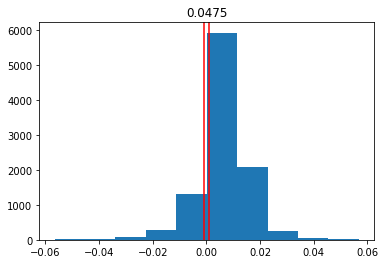

In [28]:
plt.axvline(z_tol, c='red')
plt.axvline(-z_tol, c='red')
plt.hist(train_dataset.zs - train_preds)
plt.title(sci_standard(train_dataset.zs, train_preds))
plt.show()

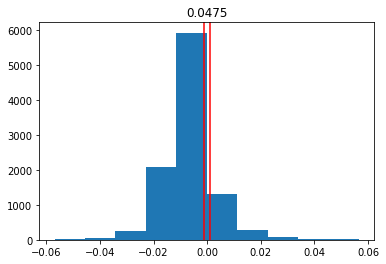

In [29]:
plt.axvline(z_tol, c='red')
plt.axvline(-z_tol, c='red')
plt.hist(val_preds - val_dataset.zs)
plt.title(sci_standard(val_preds, val_dataset.zs))
plt.show()